[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/longhowlam/python_hobby_stuff/blob/master/german_credit.ipynb)

# Introduction

This notebook shows the analysis results of the German credit data set, as part of the assessment for EE The data set I used in this notebook is dowloaded from Kaggle. See the data on Kaggle[ here](https://www.kaggle.com/btolar1/weka-german-credit?select=credit-g.csv). 

My first weapons of choice for structured (i.e. tabular) data like the german credit data set are **pandas**, **pandas-profiling**, [**plotly-express**](https://plotly.com/python/plotly-express/) and [**sweetviz**](https://github.com/fbdesignpro/sweetviz). The main modeling tool I am using here is [**pycaret**](https://pycaret.gitbook.io/docs/). It is a low code tool that is essentially a wrapper around other ML tools such as  scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, etc. The uniform low code approach which will benefit readability and maintainability of ML code, while on the other hand the code does allow for enough flexbility to tweak models if needed. Moreover, it provides interactive explorative data analysis.

This notebook was created on google colab. It is a convenient analysis environment, it provides a free python run-time environment accessible from just a browser. Moreover, there are already a lot python packages installed. And as bonus, the interactive [data table viewer](https://colab.research.google.com/notebooks/data_table.ipynb) inside colab notebooks are very handy to browse and glance trough data.  

**Alternatively**, create a conda environment with the neccesary packages. And use jupyter lab (locally) or Visual Studio Code as the environments to edit notebooks

    conda create -n mypycaret python=3.8
    conda activate mypycaret 
    pip install pycaret[full] xgboost sweetviz shap

Installing pycaret will make use of scikit-learn 0.23 instead of the later 0.24, which is not yet suported by pycaret. 



# German Credit Introduction

The german credit data set is a data set with 1000 loan applicants, each row is a loan applicant. There are twenty input variables, i.e. loan and loan-applicant characteristics and there is one binary target. The target tells us whether the loan is considerd bad or good.

# Installs and packages needed

In [ ]:
### install pycaret, shap and autoviz, other packages are already available on google colab
!pip install pycaret[full]
!pip install shap
!pip install sweetviz

In [56]:
#### python packages needed
import pandas as pd
import numpy as np

from pycaret.classification import *

import plotly.express as px
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

# Data Import 

In [21]:
german_credit = pd.read_csv('credit-g.csv')

### Create a numerical target with 1 for good and 0 for bad, that is usefull for plotting good/bad ratios.
german_credit['num_target'] =  np.where(german_credit['class'] == 'good', 1, 0)
german_credit.shape

(1000, 22)

In [22]:
### we are goint to replace some charachters in certain category levels
### xgboost doesn't like column names with <, these will appear when doing one-hot encoding with pycaret

german_credit["checking_status"] = german_credit["checking_status"].replace( {'<': '_LT_', '=':'', '>':'_GT_' }, regex=True)
german_credit["savings_status"] = german_credit["savings_status"].replace( {'<': '_LT_', '=':'', '>':'_GT_' }, regex=True)
german_credit["employment"] = german_credit["employment"].replace( {'<': '_LT_', '=':'', '>':'_GT_' }, regex=True)

In [23]:
german_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [24]:
german_credit.head(5)

checking_status  duration  ... class num_target
0           _LT_0         6  ...  good          1
1   0_LT_X_LT_200        48  ...   bad          0
2     no checking        12  ...  good          1
3           _LT_0        42  ...  good          1
4           _LT_0        24  ...   bad          0

[5 rows x 22 columns]

# Data Exploration

We are going to use **pandas profiling** to glance through visuals to get a first understanding of the data. The visuals can be displayed in the notebook, or because a lot of visuals are created, it might be more convenient to export the output to a html file from which it is easier to dive into the visuals. Either way, there is no shortcut, you should glance trough visuals.

Moreover, in real use cases, often you need to confront the business with 'strange' or counter intuitive findings. This will give you more reassurance that the data is OK or that you have tackled data issues.

## Profiling report

In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(german_credit, interactions=None,  title="German Credit Profiling Report")
prof.to_file(output_file='german_credit_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
### display profile report in the notebook
prof

## Target - Input profiles

By looking at the 'correlations' secion of the pandas-profiling output, we already got some idea what input variables correlate (strongly) with the target variable. From a first glance, we see that the input variables 

+ checking status, 
+ duration and 
+ saving status 

correlate (strongly) with the target.


We are going to dive in a bit deeper here. We are not only interested in whether or not there is correlcation between an input variable and the target, we want to get an understanding in the relationship between an input variable and the target.


The following plots make use of the numerical target (being 1 for good and 0 for bad). When using lowess smoothing (or just averages for categorical variables) we immediately get the good/bad ratio estimated for certain values of the inputs.

[Text(0.5, 1.0, 'Good / bad rate vs checking status')]

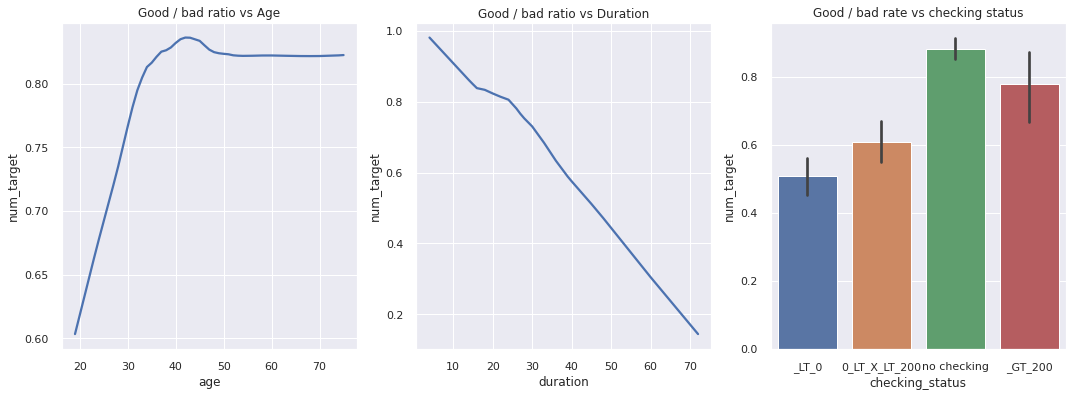

In [59]:
fig, axs = plt.subplots(ncols=3,  figsize=(18,6))

sns.regplot(
    x = "age", 
    y = "num_target", 
    data = german_credit, 
    lowess=True,
    scatter = False,
    ax=axs[0]
).set(title='Good / bad ratio vs Age')

sns.regplot(
    x = "duration", 
    y = "num_target", 
    data = german_credit, 
    lowess=True,
    scatter = False,
     ax=axs[1]
).set(title='Good / bad ratio vs Duration')

sns.barplot(
    x = "checking_status", 
    y = "num_target", 
    data = german_credit,
    ax=axs[2]
).set(title = "Good / bad rate vs checking status")

### Sweetviz

A nice alternative to create **target - input variable profile plots** manually for all interesting input variables as I did above, is to make use of the [Sweetviz](https://github.com/fbdesignpro/sweetviz) package. It automatically profiles each input variable against the target.



In [ ]:
target_analysis = sv.analyze(german_credit, target_feat = 'num_target')

                                             |          | [  0%]   00:00 -> (? left)


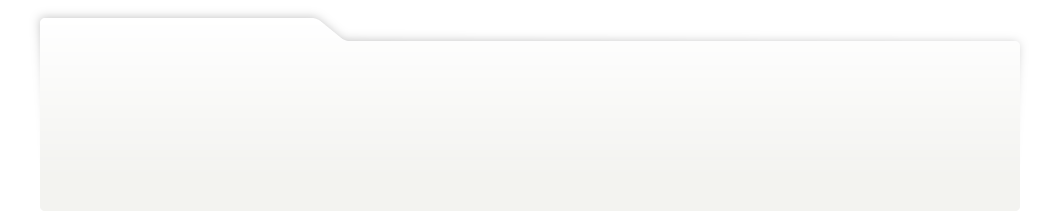
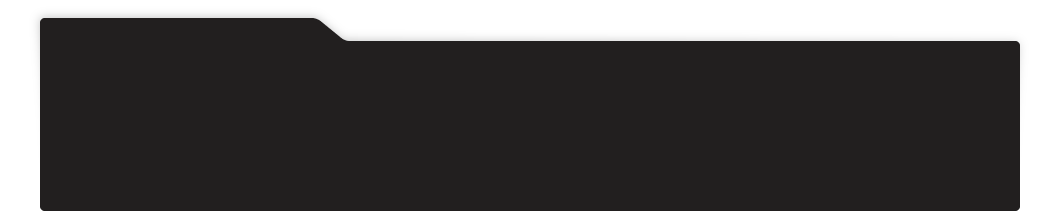
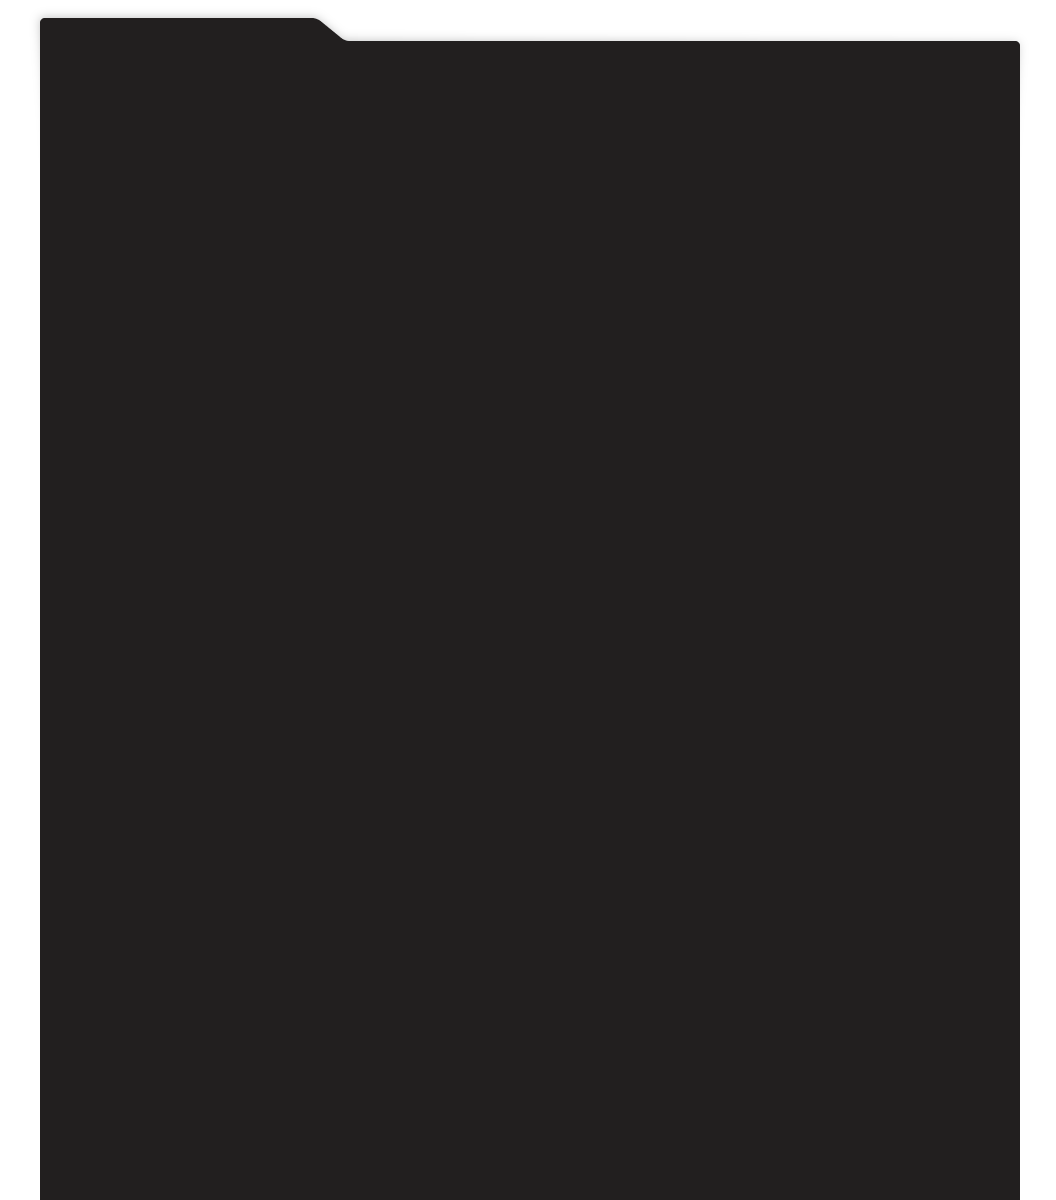
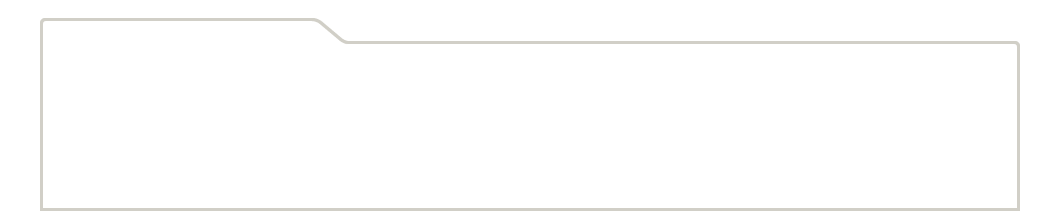
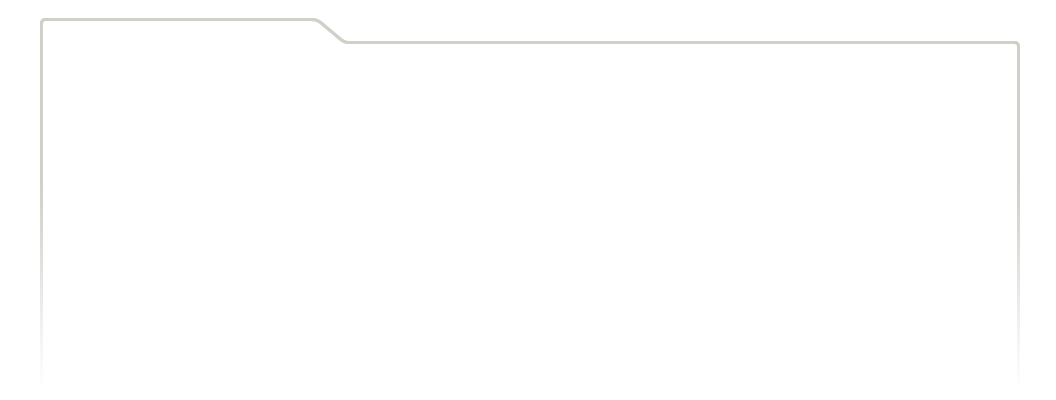
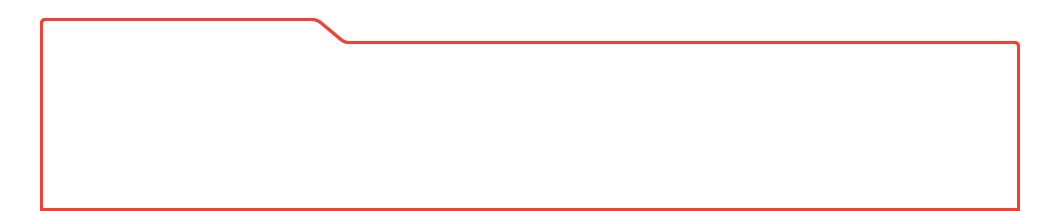
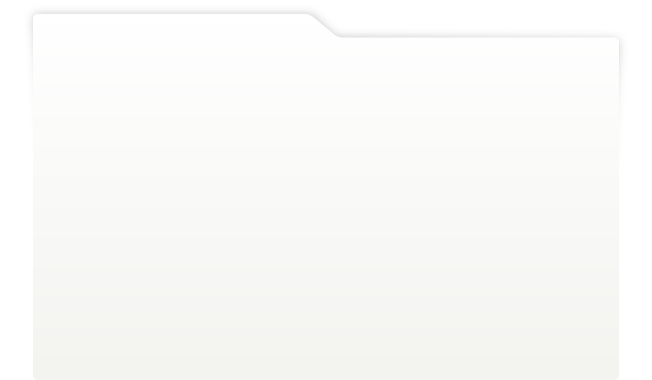
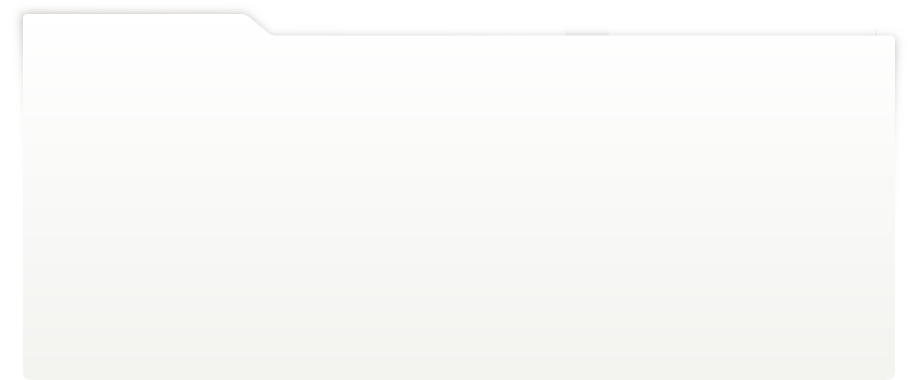
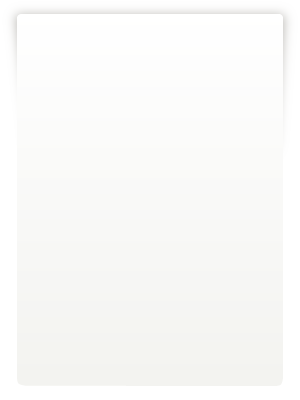
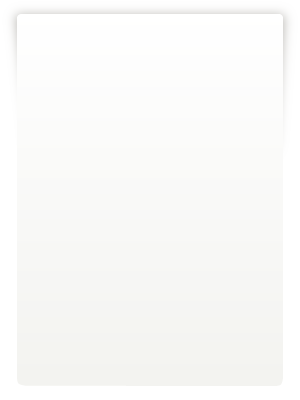
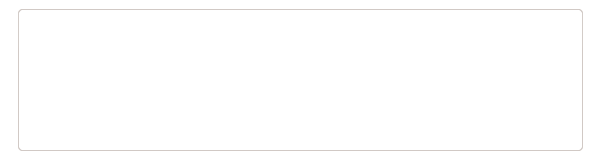
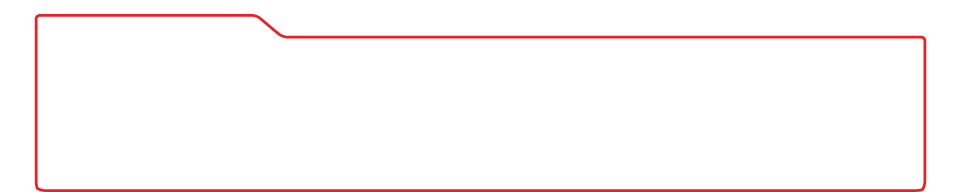
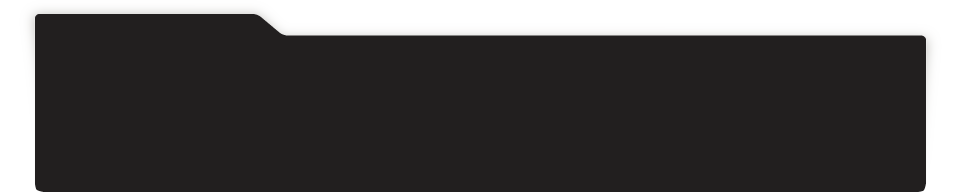
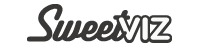
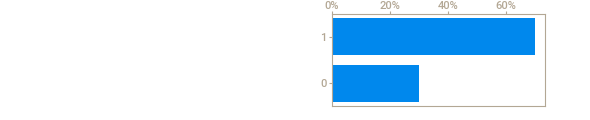
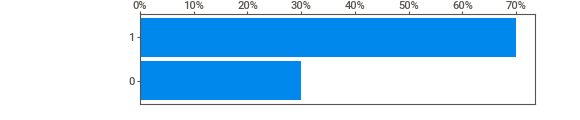
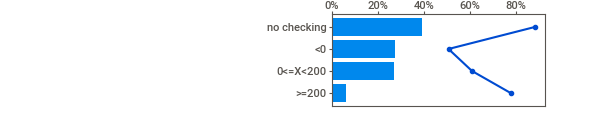
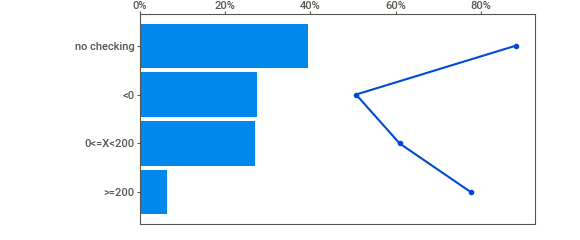
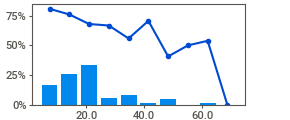
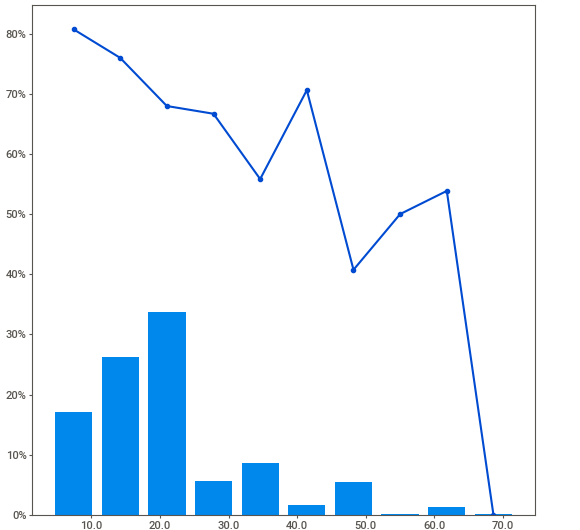
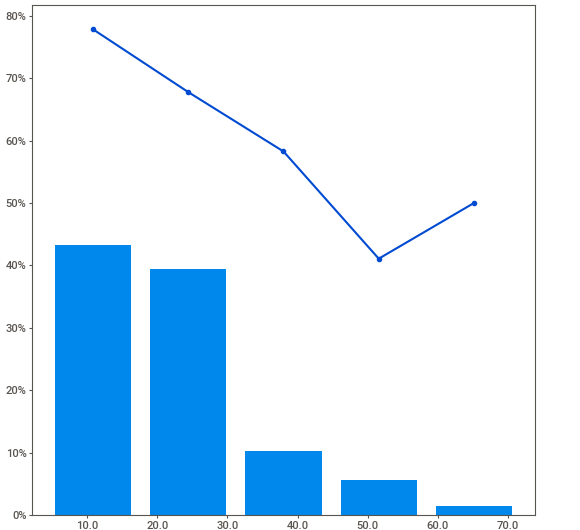
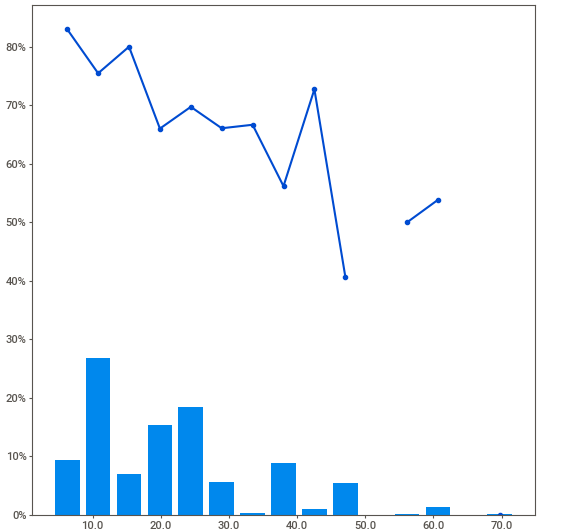
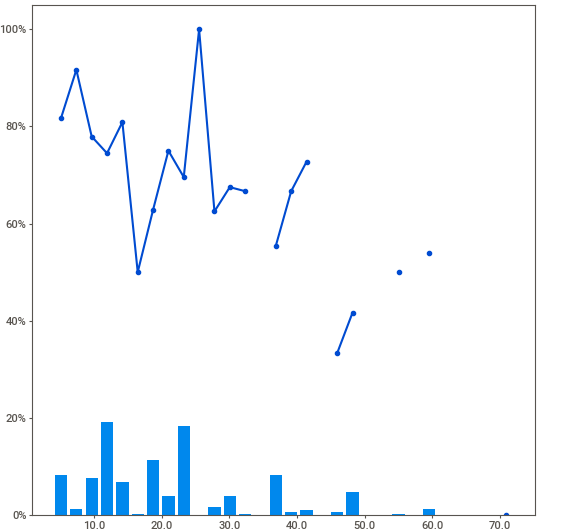
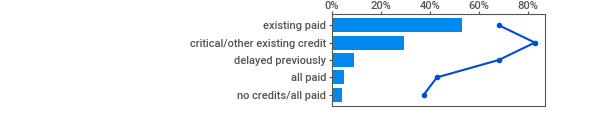
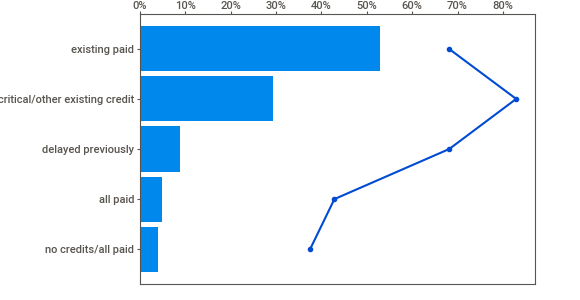
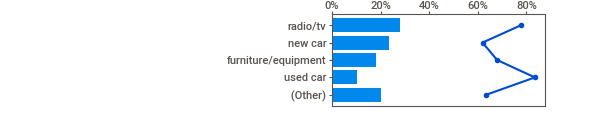
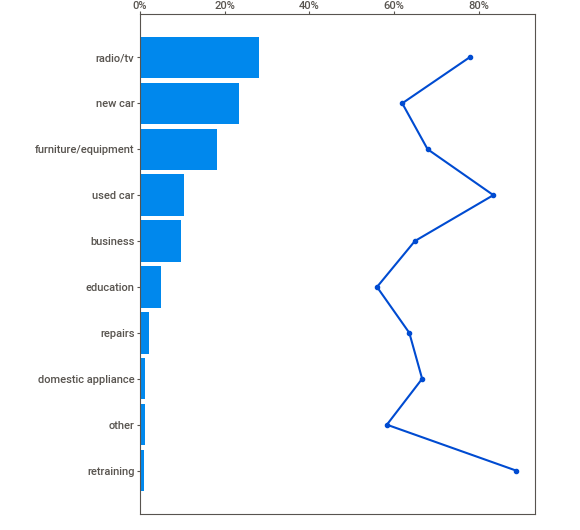
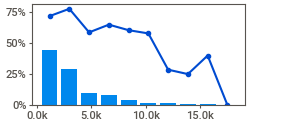
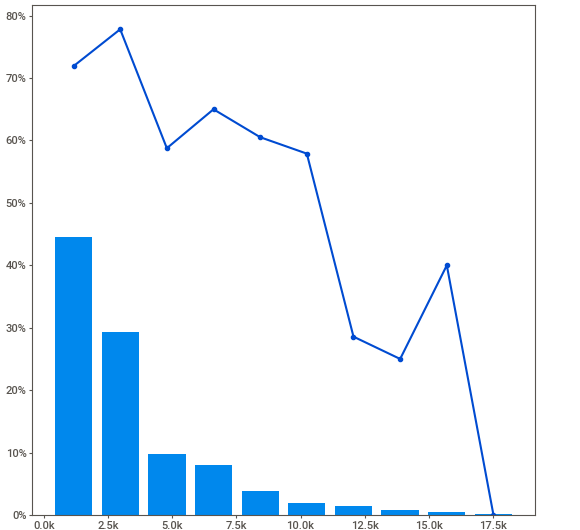
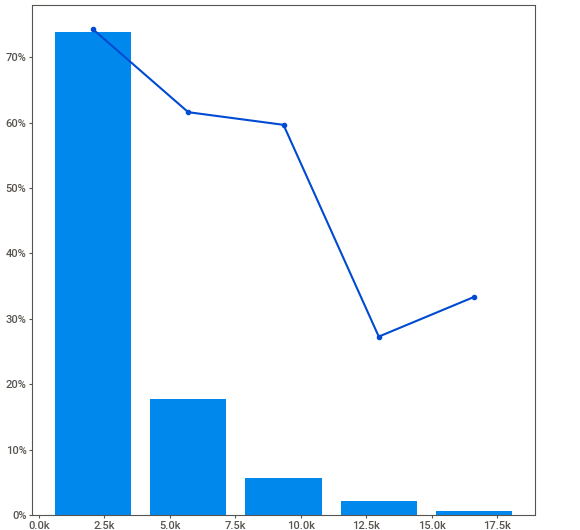
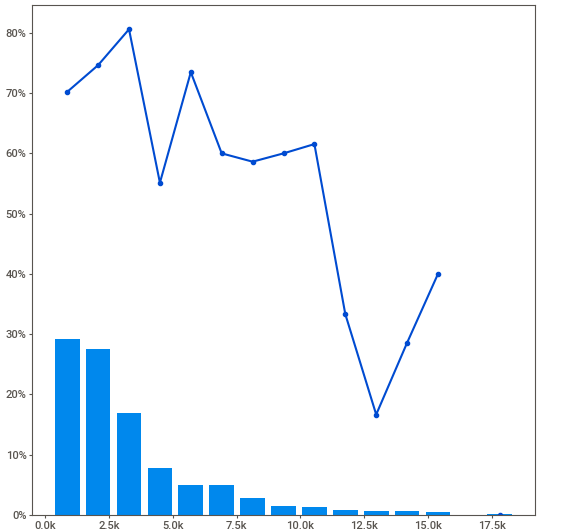
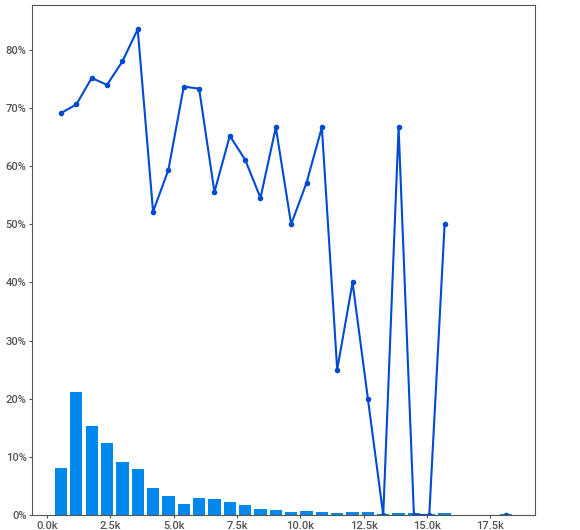
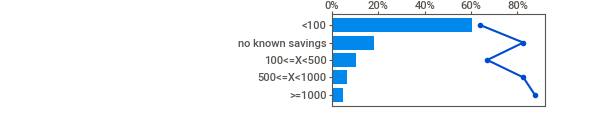
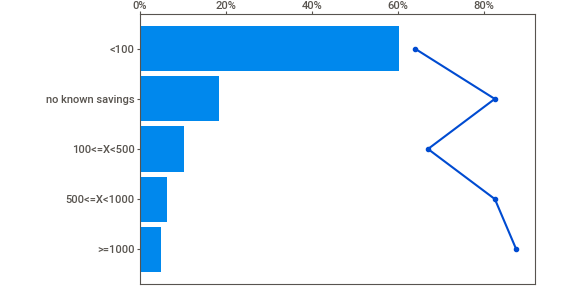
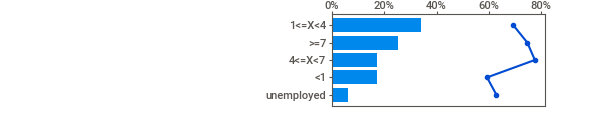
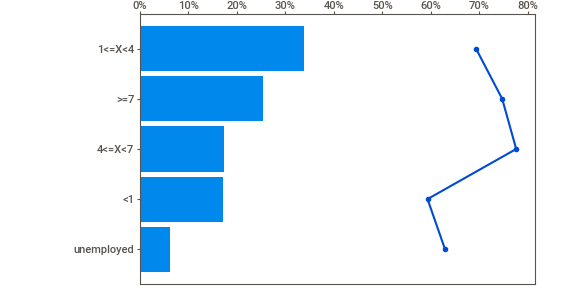
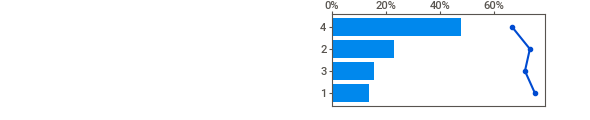
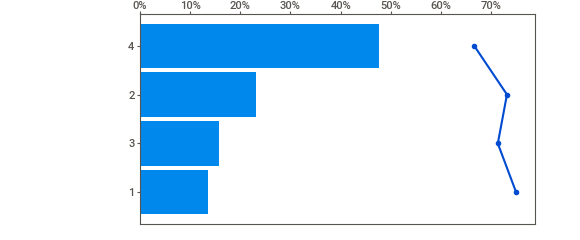
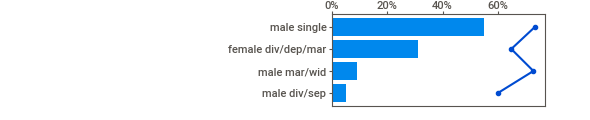
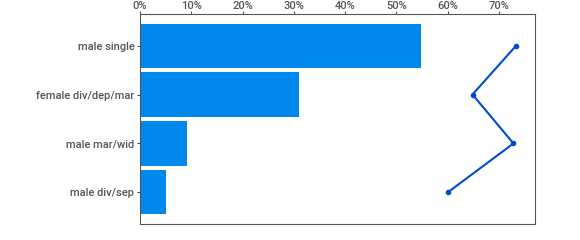
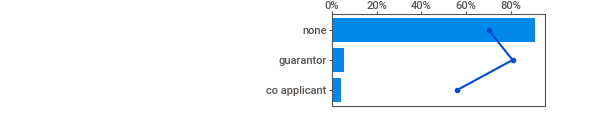
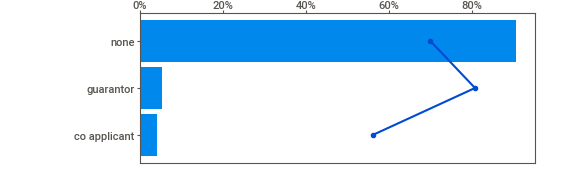
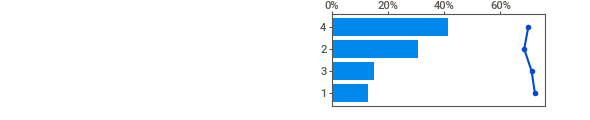
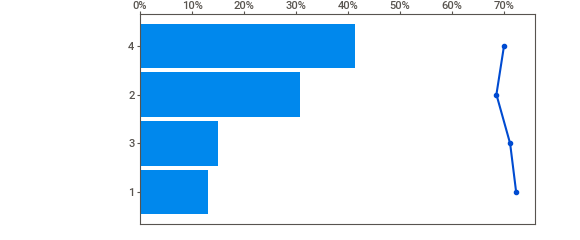
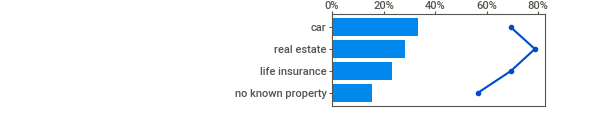
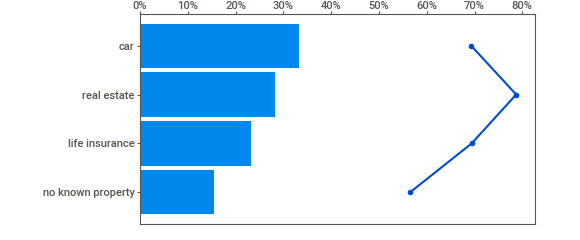
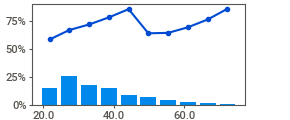
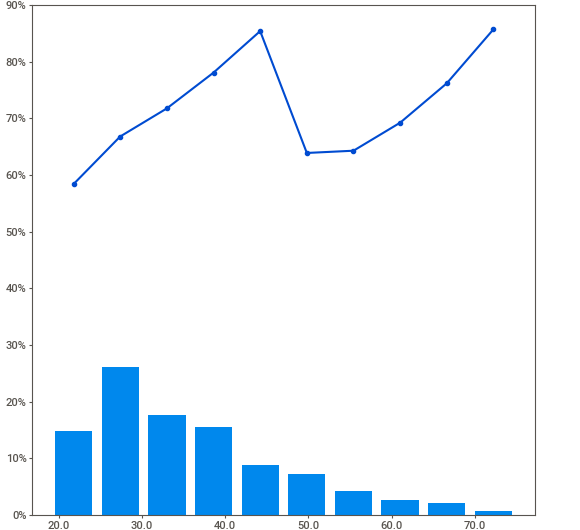
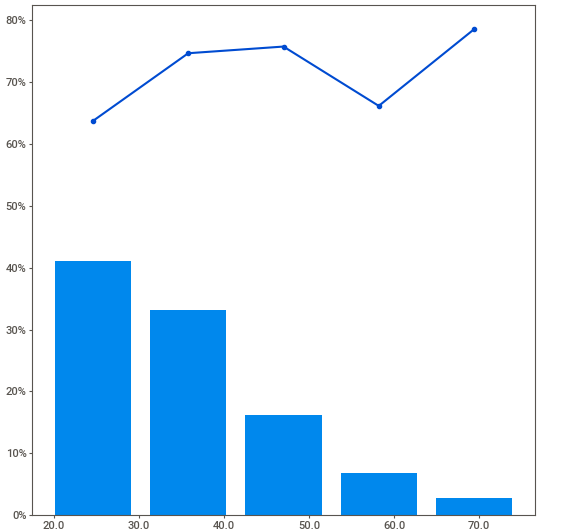
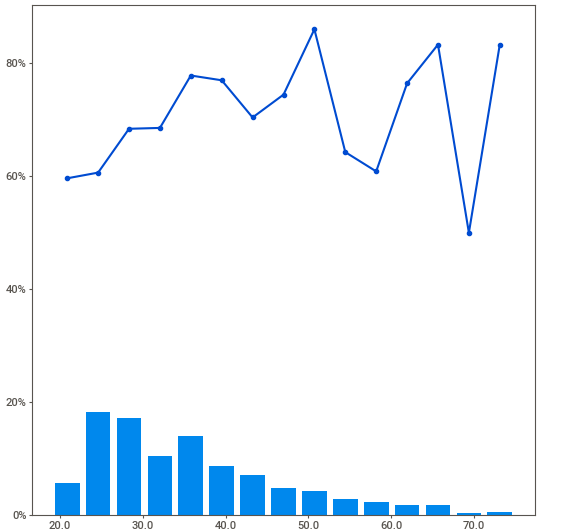
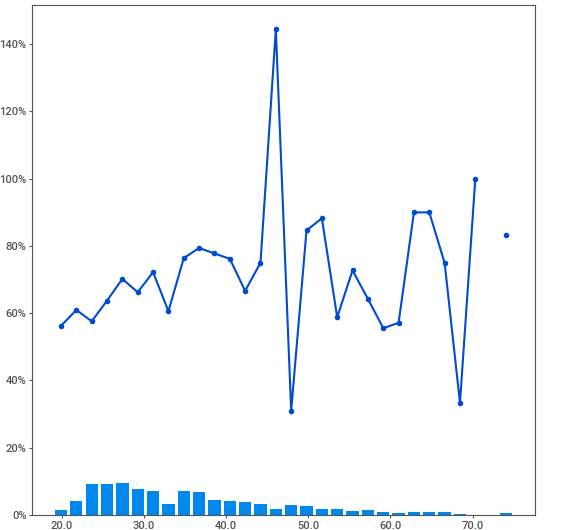
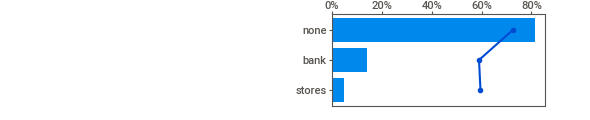
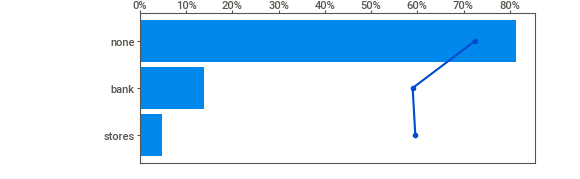
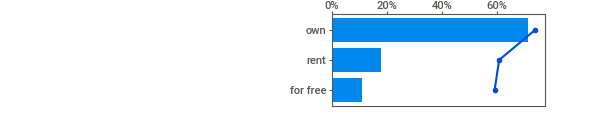
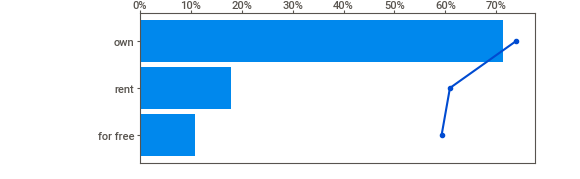
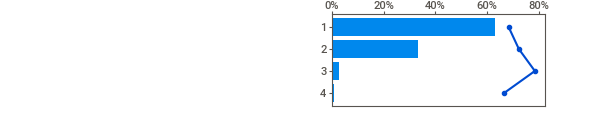
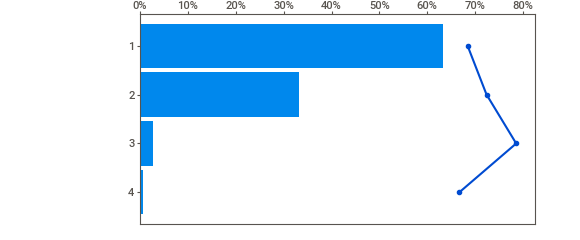
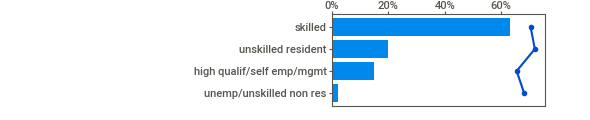
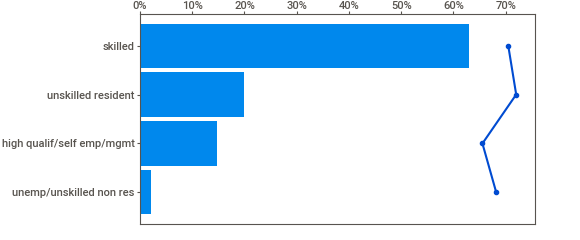
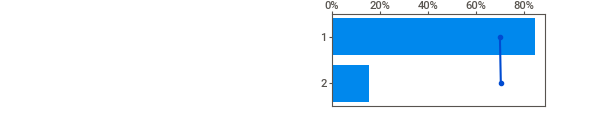
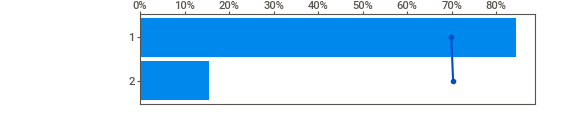
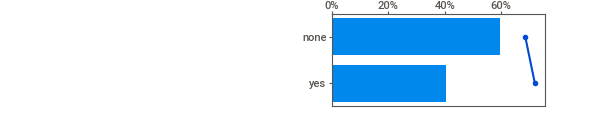
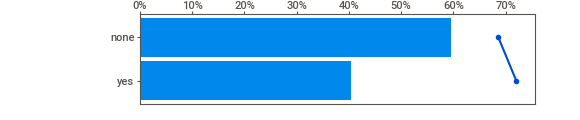
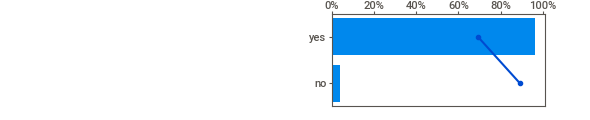
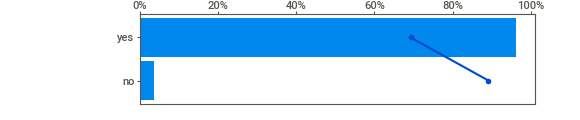
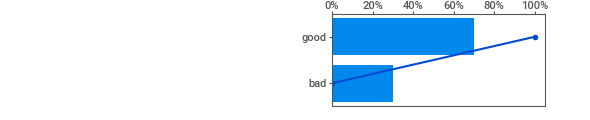
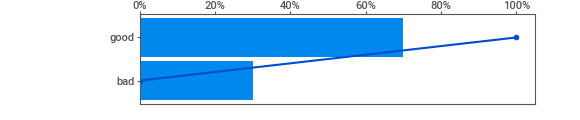
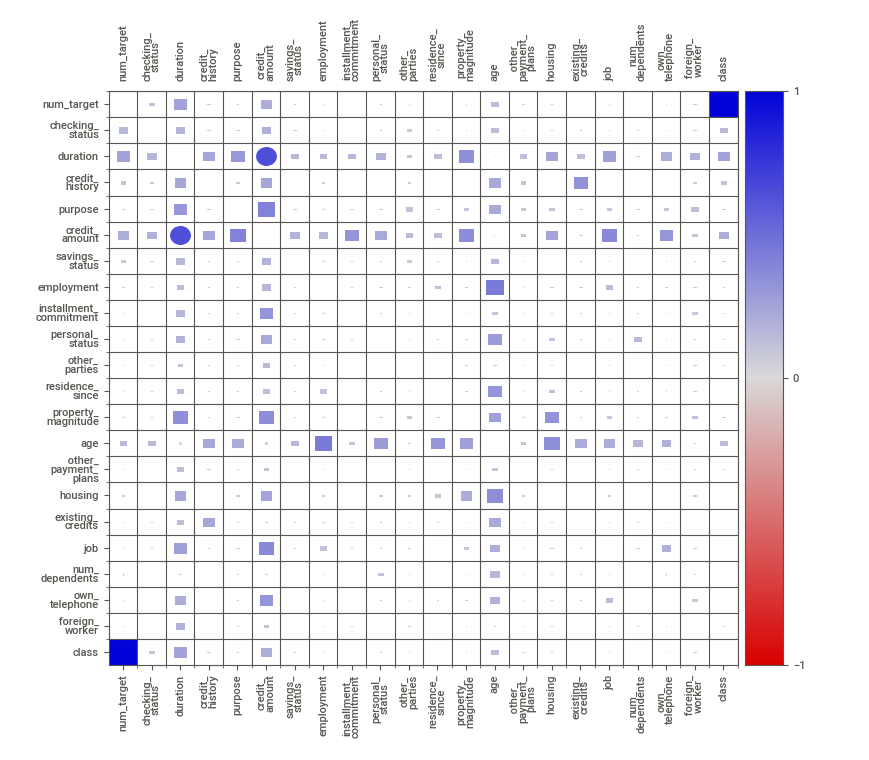
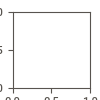

In [ ]:
target_analysis.show_notebook( layout='widescreen')

## Things to notice/consider

#### **Target class**
We see a 'good rate' of 70%, i.e. 70% percent of the applicants are classified as good and 30% as bad. This is not a real extreme unbalanced situation, and the balance in this data set is probably already 'artificial' generated by having added more bad loans in the this data set. In real loan portfolios from banks a 30% rate of bad loans would often mean 'end-of-business', you typically would see bad rates of 1 or 2 percent........  

#### **Checking status**  and **saving status**
A large portion of the applicants do not have a checking account. One might consider sub models for applicants having a checking account and for applicants who have no checking account. When a bank that provides the loan also has the applicant as a checking account customer, then additional interesting financial info can be derived that will influence the probability of loan repayment. And from the sweetviz visual we do see increasing 'good rates' when here is a higher checking balance.

Same could be said for saving status, the more saving you have the higher the 'good rate'. You need to be awre of potential biasses here. The more balances on savings or checking accounts, the less likely it is you need a loan in the first place.

#### **Duration**

Typically loans would have durations of 12, 24,36, etc months (whole years). We do see loans that 'deviate' from these 'whole years' durations. What kind of loans are they? Do they go trough different application process. When an applicant wants a loan of '16 months' is that taylored to a specific situtaion of the applicant? Overall pattern is that the shorter duration of the loan the higher the 'good rate' is


#### **Loan purpose**
A high good rate for 'used cars'. When the applicant gets into financial trouble, the value of used cars are reasable stable and he could sell the car to repay the loan. That may not be the case for other goods, as we see in the visual.

#### **Personal status**
This is a sensitive input variable. It isn't strongly correlated with the target, but you don't want to run the risk of discriminating based on gender. In building credit risk models it is forbidden to use this variable explicitly. And even so you could do a subpopulation analysis to see if your model is biased towards gender.

#### **Age**
There is a funy drop in good rate visible at around the age of 50 years. Could this be children related? At that age people who have children might face extra financial spend, school, uni etc? In terms of modeling, this is not a monotone relation, could be an issue in logistic regression for example.


### Infrequent category levels
Be aware of input variables with infrequent category levels, but with potentially high (or low) risk!  Two examples here might be 'foreign_worker' and 'other_parties'. We see a small number of applicants which are classed as '*co applicant*', they have a high bad rate. They might not appear or come up in the final predictive model because of the (very) low occurence. But they could be included as a business rule.

### Missing data

Be prudent when there are missing values! Sometimes the data analists fill in the blanks of missing numerical data with the median or mean value. Or in case when the missing data is categorical, the blank is filled in with the most occuring category level. I think that is a bad thing to do.

1. Find out why the data is missing, and see if missing data can occur when applying the model.
2. Missing value can be a category on its own. I.e. Credit Purpose, missing we could set the category to unknown. 
3. In case of credit scoring, be prudent, don't give *the benefit of the doubt*. Prevent the loan applicant from 'hacking the system' by rather giving no income than a 'bad income'. Or he might not fill in a loan purpose when the money is used for a risky business.....


Often the final scoring system for loan applicants is not just only the predictive models but also a set of 'business rules'. In case of missing info at the loan application, the loan shouldn't pass automatically.

### Correlations and interactions


jfhskdjhslghs;gh;kgjhd;kghd;gk

### Strategy when there are many variables

The German credit data set is a small data set, both in terms of number of variables and number of records. In real life banking loan data, one might have hundreds of potential input variables. In credit scoring, well in any predictive modeling, its very unlikely that you would need all of those hundreds of input variables in the final model.


A first shifting should be done. This can be done with fitting an initial model, say a random forest. Then for this model we could look at the top 20 or 30 impportant variables. If there is enough data, ideally this would be done on a seperate sample of the data, in that case you would not mix variable selecting with model training/testing and validation. Then proceed with the selected variables towards a final model and drop the rest of the variables.



# Predictive Models with Pycaret

In this secion we try different models and chose one model. With Pycaret you need to setup an 'experiment' first.

For the German Credit data set, the data set is very small, so we do not have the luxury to split the data in many pieces. In general it is good practice to "learn something" from the data (i.e. what variables are important) on a separate part of the data. Thus, preventing 'leakage of information' when using the same data to 'learn' something else (i.e. train the model and get performance and model generalisation KPI's).

In any case, Pycarets default setup will split the data into two parts, train/holdout 70/30. On the train part Pycaret will use cross validation with ten folds to come up with estimates of the model performances like AUC, F1, Kappa, etc. There are many more things you can set, such as how to deal with outliers, correlated variables, missing data etc. We are not going to dive into that here.

The holdout set is used to evaluate the final model.

In [25]:
### we have two targets in the data set, one numerical and one class, we need to ignore one target, 
### and also we need to ignore the sensitive input 'personal_status' 

gc_model_setup = setup(
    data = german_credit, 
    target = 'num_target', 
    session_id=123, 
    silent = True,
    ignore_features =  ['class', 'personal_status']
  )  

Description             Value
0                               session_id               123
1                                   Target        num_target
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data        (1000, 22)
5                           Missing Values             False
6                         Numeric Features                 3
7                     Categorical Features                16
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set         (699, 64)
12                    Transformed Test Set         (301, 64)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              556b
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

In [26]:
### Get an overview of performances for different models.
best_model = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7568  0.7623  0.9179  0.7810   
ridge                    Ridge Classifier    0.7497  0.0000  0.8878  0.7889   
lr                    Logistic Regression    0.7439  0.7578  0.8798  0.7879   
rf               Random Forest Classifier    0.7425  0.7482  0.9198  0.7669   
lightgbm  Light Gradient Boosting Machine    0.7382  0.7315  0.8758  0.7841   
lda          Linear Discriminant Analysis    0.7368  0.7579  0.8578  0.7917   
et                 Extra Trees Classifier    0.7353  0.7128  0.8858  0.7761   
ada                  Ada Boost Classifier    0.7311  0.7282  0.8598  0.7842   
gbc          Gradient Boosting Classifier    0.7311  0.7379  0.8838  0.7725   
xgboost         Extreme Gradient Boosting    0.7225  0.7096  0.8577  0.7784   
dummy                    Dummy Classifier    0.7139  0.5000  1.0000  0.7139   
nb                            Naive Bayes    0.6982  0.7216  0.7356  0.8235   
knn                K Neighbors Classifier    0.6638  0.5328  0.8556  0.7239   
dt               Decision Tree Classifier    0.6525  0.5978  0.7256  0.7727   
svm                   SVM - Linear Kernel    0.5524  0.0000  0.6060  0.5122   
qda       Quadratic Discriminant Analysis    0.3790  0.5336  0.1722  0.8121   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.8436  0.3115  0.3336     1.813  
ridge     0.8351  0.3217  0.3328     0.020  
lr        0.8308  0.3094  0.3188     0.126  
rf        0.8362  0.2556  0.2798     0.520  
lightgbm  0.8270  0.2946  0.3029     0.063  
lda       0.8232  0.3112  0.3159     0.023  
et        0.8269  0.2735  0.2862     0.507  
ada       0.8199  0.2921  0.2996     0.121  
gbc       0.8243  0.2618  0.2738     0.170  
xgboost   0.8149  0.2605  0.2698     6.906  
dummy     0.8331  0.0000  0.0000     0.012  
nb        0.7759  0.3161  0.3221     0.017  
knn       0.7840  0.0460  0.0479     0.118  
dt        0.7479  0.1897  0.1909     0.023  
svm       0.5408  0.0232  0.0097     0.020  
qda       0.2799  0.0427  0.0863     0.020

**Note** The model performance KPI's without the sensitive 'personal_status' are only slightly worse than the model with the sensitive input variable.

## Considerations

The table above shows different performances for different models. It is a first indication what type of models perform bad, good or better on this specific data set. The performance KPI's above will only partiallly help you in your final model choice.

**Keep in mind** that we have a very small data set here at hand, and as we see below the performance measures vary quit a lot from fold to fold. So, in this case, do not blindly stare on a model whose performance is slightly better in the table above.

### Keep it simple (Ockhams Razor)

I alwasy use Ockhams Razor principle.  different models Hier nog benomen ook noemen waarom LR / Tree or RF en andere bevindithe ngen

why is lrm already so good?

There is little data, lrm is efficient

### strategies when lrm is less than tree and forests 

# Focus on logistic regression model

With pycaret you can now focus on a specific model. You can either fine tune and optimize for hyper parameters. And dive deeper in the performance and explainability of the model.

We are going to diev a bit deeper into the logistic regression model

### Performance

In [27]:
GC_lrm = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7714  0.7940  0.9200  0.7931  0.8519  0.3636  0.3836
1       0.7286  0.6980  0.8800  0.7719  0.8224  0.2570  0.2672
2       0.8000  0.7650  0.9200  0.8214  0.8679  0.4615  0.4743
3       0.7143  0.7190  0.8800  0.7586  0.8148  0.2045  0.2158
4       0.8143  0.8550  0.8800  0.8627  0.8713  0.5381  0.5384
5       0.7000  0.7530  0.8200  0.7736  0.7961  0.2304  0.2318
6       0.7000  0.7250  0.8800  0.7458  0.8073  0.1503  0.1614
7       0.7429  0.7580  0.8400  0.8077  0.8235  0.3505  0.3514
8       0.7286  0.7110  0.8800  0.7719  0.8224  0.2570  0.2672
9       0.7391  0.8000  0.8980  0.7719  0.8302  0.2812  0.2968
Mean    0.7439  0.7578  0.8798  0.7879  0.8308  0.3094  0.3188
SD      0.0375  0.0458  0.0295  0.0328  0.0238  0.1135  0.1125

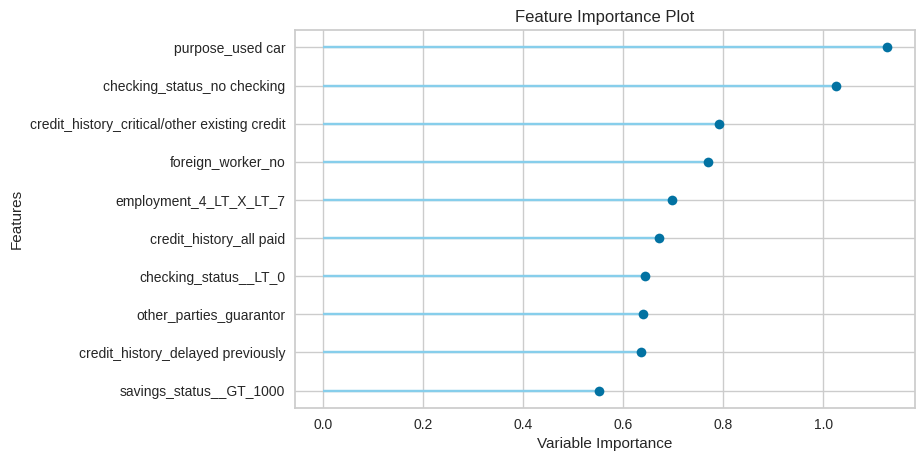

In [28]:
plot_model(GC_lrm, plot = 'feature')

Mention the importance of lift curves

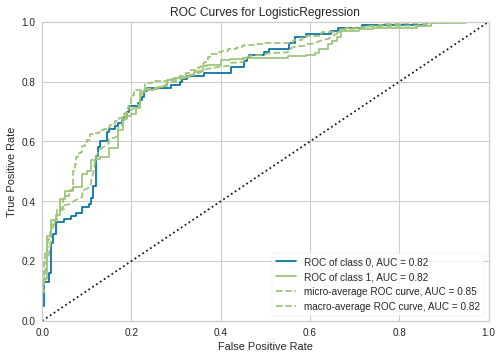

In [ ]:
plot_model(GC_lrm, plot = 'auc')

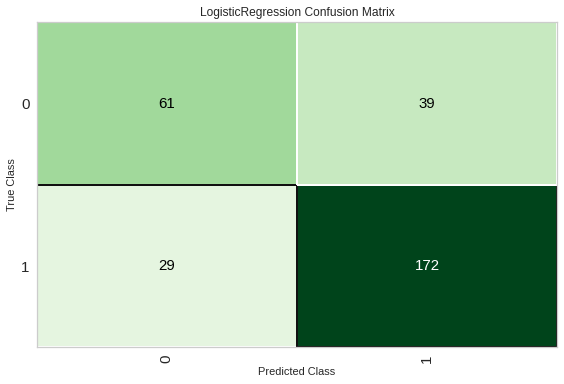

In [ ]:
plot_model(GC_lrm, plot='confusion_matrix')

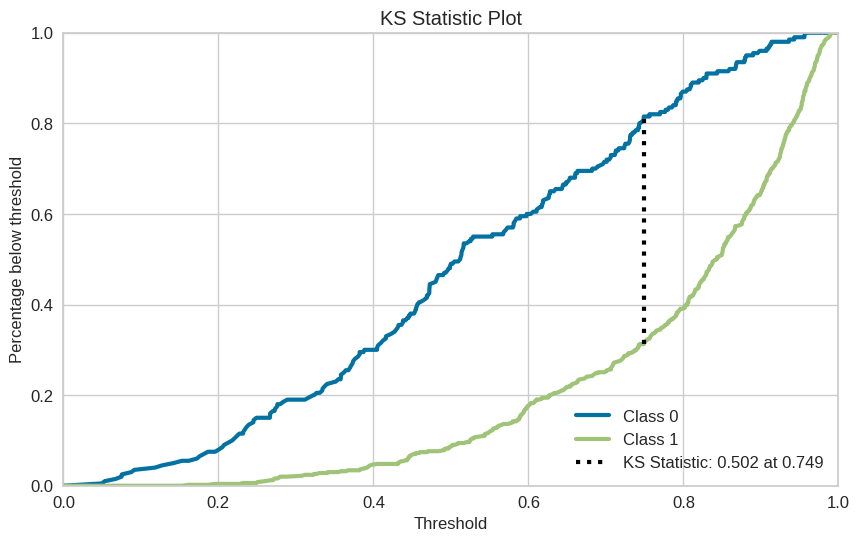

In [ ]:
plot_model(GC_lrm, plot = 'ks')

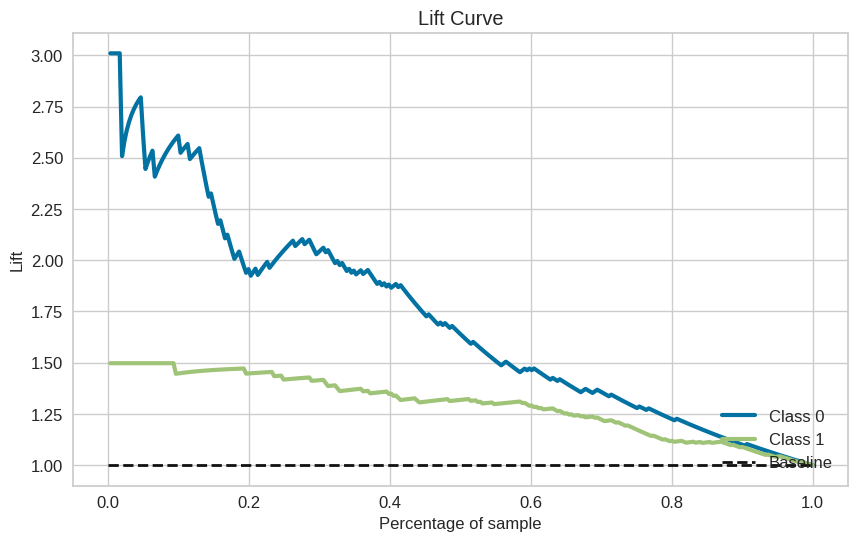

In [ ]:
plot_model(GC_lrm, plot = 'lift')

## Model explainability

Model explainability comes automatically when using logistic regression. The whole model is goverened by the set of coefficients, found during the training of the model. We get the names of the input features, because note that these are different from the column names in the german credit data set. Pycaret has taken care of creating dummy variables for categorical variables by using one-hot encoding.

Then we extract the set of coefficients from the logistic regression model object. and put it in a frame for presentation purposes.

In [ ]:
model_presentation = pd.DataFrame({
    'input_name' : np.append( get_config(variable="X_train").columns, 'intercept'),
    'coefficient': np.append( GC_lrm.coef_[0,:], GC_lrm.intercept_)
})

with pd.option_context("display.max_rows", 1000):
    display(model_presentation)


input_name  coefficient
0                                        duration    -0.036139
1                                   credit_amount    -0.000109
2                                             age     0.007108
3                       checking_status_0LTXLT200    -0.095176
4                           checking_status_GT200     0.139620
5                             checking_status_LT0    -0.644088
6                     checking_status_no checking     1.025512
7                         credit_history_all paid    -0.671261
8   credit_history_critical/other existing credit     0.791832
9               credit_history_delayed previously     0.635458
10                   credit_history_existing paid     0.021442
11             credit_history_no credits/all paid    -0.351603
12                               purpose_business    -0.037293
13                     purpose_domestic appliance    -0.056752
14                              purpose_education    -0.486033
15                    purpose_furniture/equipment    -0.107791
16                                purpose_new car    -0.483867
17                                  purpose_other     0.284878
18                               purpose_radio/tv     0.127841
19                                purpose_repairs    -0.214045
20                             purpose_retraining     0.272531
21                               purpose_used car     1.126397
22                     savings_status_100LTXLT500    -0.106507
23                    savings_status_500LTXLT1000     0.023397
24                          savings_status_GT1000     0.551322
25                           savings_status_LT100    -0.334848
26                savings_status_no known savings     0.292504
27                             employment_1LTXLT4     0.025472
28                             employment_4LTXLT7     0.696328
29                                 employment_GT7     0.058477
30                                 employment_LT1    -0.475167
31                          employment_unemployed     0.120758
32                       installment_commitment_1     0.406124
33                       installment_commitment_2     0.119301
34                       installment_commitment_3     0.163553
35                       installment_commitment_4    -0.263111
36                     other_parties_co applicant    -0.139690
37                        other_parties_guarantor     0.639777
38                             other_parties_none    -0.074219
39                              residence_since_1     0.330469
40                              residence_since_2    -0.149053
41                              residence_since_3    -0.002384
42                              residence_since_4     0.246836
43                         property_magnitude_car     0.251645
44              property_magnitude_life insurance     0.054136
45           property_magnitude_no known property    -0.059683
46                 property_magnitude_real estate     0.179769
47                       other_payment_plans_bank     0.110514
48                       other_payment_plans_none     0.479601
49                     other_payment_plans_stores    -0.164247
50                               housing_for free     0.150504
51                                    housing_own     0.505683
52                                   housing_rent    -0.230320
53                             existing_credits_1     0.298765
54                             existing_credits_2    -0.165585
55                             existing_credits_3     0.243431
56                             existing_credits_4     0.049256
57                  job_high qualif/self emp/mgmt     0.212928
58                                    job_skilled    -0.100462
59                    job_unemp/unskilled non res     0.215448
60                         job_unskilled resident     0.097954
61                               num_dependents_1     0.189047
62                             own_telephone_none    -0.132112
63     

## Explainability for more complex models

In [ ]:
GC_catb = create_model('catboost')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7429  0.7740  0.9200  0.7667  0.8364  0.2588  0.2840
1       0.7143  0.7240  0.9000  0.7500  0.8182  0.1765  0.1936
2       0.8000  0.7490  0.9800  0.7903  0.8750  0.4024  0.4686
3       0.7143  0.7280  0.9000  0.7500  0.8182  0.1765  0.1936
4       0.8143  0.8530  0.9200  0.8364  0.8762  0.5081  0.5175
5       0.7571  0.7810  0.9000  0.7895  0.8411  0.3352  0.3485
6       0.7286  0.7600  0.9400  0.7460  0.8319  0.1739  0.2108
7       0.7286  0.7110  0.9000  0.7627  0.8257  0.2312  0.2483
8       0.7571  0.7460  0.8800  0.8000  0.8381  0.3568  0.3633
9       0.7391  0.8102  0.9184  0.7627  0.8333  0.2563  0.2814
Mean    0.7496  0.7636  0.9158  0.7754  0.8394  0.2876  0.3110
SD      0.0322  0.0409  0.0265  0.0270  0.0195  0.1056  0.1071

In [ ]:
interpret_model(GC_catb, plot = 'pdp', feature = 'duration') 

In [ ]:
interpret_model(GC_catb, plot='reason', observation=0)

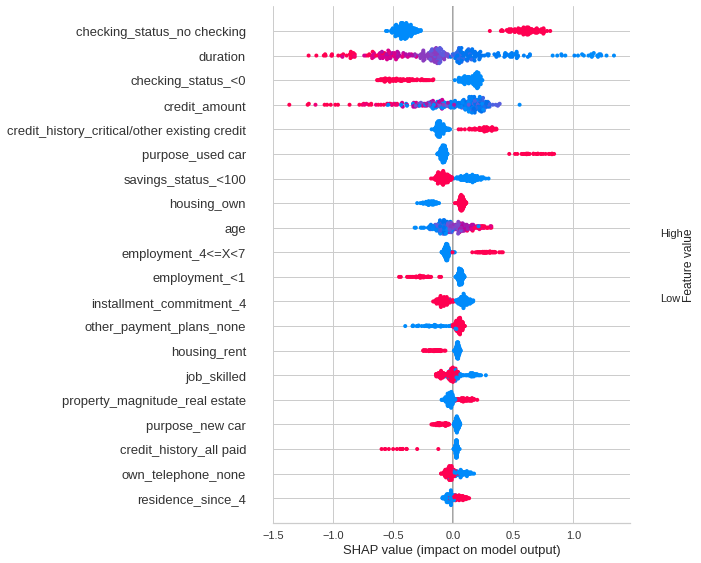

In [ ]:
interpret_model(GC_catb)

## AI Fairness

There are different apporaches to AI faireness, however, one important question you should ask as a creator of machine learning model is this: are there groups of individuals (in terms of race, gender or other 'sensitive' variables) for which your model is biased. I.e. in case of credit scoring, are there groups of individuals who are less likely to receive a good score from the model.

We did not use 'personal status' as a driver in the model. However, your model could still be biased because of other data inputs in the model that could (strongly) relate to a sensitive driver such as 'personal status'.

We apply the model on the holdout set and see if perforamnce measures differ (strongly) on the individual categories. If there is no biass then these measures would be the roughly the same 



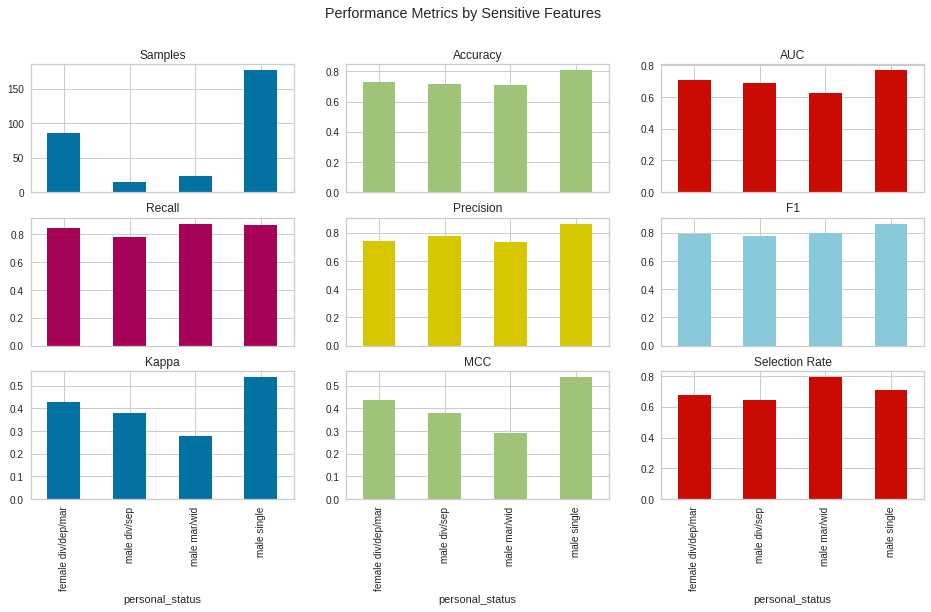

In [29]:
lr_fairness = check_fairness(GC_lrm, sensitive_features = ['personal_status'])

In [30]:
lr_fairness

Samples  Accuracy  ...       MCC Selection Rate
personal_status                       ...                         
female div/dep/mar      86  0.732558  ...   0.43463       0.674419
male div/sep            14  0.714286  ...  0.377778       0.642857
male mar/wid            24  0.708333  ...  0.290191       0.791667
male single            177   0.80791  ...  0.537077       0.706215

[4 rows x 9 columns]

The samples are small here, so it is hard to say anything conclusive here. But looking the 'selection rate' (i.e the fraction of predicted labels matching a good outcome) we see the model biased towards a high "male maried widow" compared to "female div/dep/mar".

# conclusion

In [ ]:
Conclusion